In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

In [2]:
import time

## Parameters

In [3]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 16,
    "epochs": 25,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/model_checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [4]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [5]:
X_train = torch.load("../data/processed/noisy/train/x_train.pt")
y_train = torch.load("../data/processed/noisy/train/y_train.pt")
X_val = torch.load("../data/processed/noisy/val/x_val.pt")
y_val = torch.load("../data/processed/noisy/val/y_val.pt")

## Data Generators

In [6]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, y_train)
lsg_val = LibriSpeechGenerator(config, X_val, y_val)

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [7]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1),
                mode="deconv")
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [8]:
model = SEWUNet(config)

In [9]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [10]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [11]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

# Print validation metric before trainer
print("SNR (Validation): {}".format(m_snr(lsg_val.X, lsg_val.y).item()))

SNR (Validation): 10.05069351196289


In [12]:
# Copy model to device
model = model.to(device)

In [13]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1259572

In [14]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [15]:
# Train the model over epochs
steps = len(ls_generator)
start_time = time.time()

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Checkpoint the model
    torch.save(model.state_dict(), config.checkpoint_path)
    
    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)

elapsed_time = time.time() - start_time
history['elapsed_time'] = elapsed_time

Epoch [01/25], Step [100/1803], Loss: 0.05473051965236664, SNR: -3.2239551544189453
Epoch [01/25], Step [200/1803], Loss: 0.020575430244207382, SNR: 2.7811977863311768
Epoch [01/25], Step [300/1803], Loss: 0.02033960074186325, SNR: 4.5944013595581055
Epoch [01/25], Step [400/1803], Loss: 0.014637280255556107, SNR: 7.072195053100586
Epoch [01/25], Step [500/1803], Loss: 0.017390117049217224, SNR: 6.698851108551025
Epoch [01/25], Step [600/1803], Loss: 0.014986532740294933, SNR: 7.638518333435059
Epoch [01/25], Step [700/1803], Loss: 0.012788310647010803, SNR: 8.781002044677734
Epoch [01/25], Step [800/1803], Loss: 0.014047808945178986, SNR: 8.477258682250977
Epoch [01/25], Step [900/1803], Loss: 0.017903342843055725, SNR: 7.726228713989258
Epoch [01/25], Step [1000/1803], Loss: 0.022160548716783524, SNR: 8.40881061553955
Epoch [01/25], Step [1100/1803], Loss: 0.012669771909713745, SNR: 9.56650161743164
Epoch [01/25], Step [1200/1803], Loss: 0.012064819224178791, SNR: 10.092784881591797


.:. Validation metrics = Loss: 0.008399375910552736, SNR: 13.201644641701678
Epoch [06/25], Step [100/1803], Loss: 0.01073942705988884, SNR: 13.269275665283203
Epoch [06/25], Step [200/1803], Loss: 0.010253725573420525, SNR: 12.212249755859375
Epoch [06/25], Step [300/1803], Loss: 0.013425052165985107, SNR: 12.214350700378418
Epoch [06/25], Step [400/1803], Loss: 0.008944828063249588, SNR: 12.218657493591309
Epoch [06/25], Step [500/1803], Loss: 0.008597420528531075, SNR: 11.993618965148926
Epoch [06/25], Step [600/1803], Loss: 0.0074988375417888165, SNR: 13.716730117797852
Epoch [06/25], Step [700/1803], Loss: 0.00891093723475933, SNR: 12.989017486572266
Epoch [06/25], Step [800/1803], Loss: 0.0073180608451366425, SNR: 13.029745101928711
Epoch [06/25], Step [900/1803], Loss: 0.009781349450349808, SNR: 12.303825378417969
Epoch [06/25], Step [1000/1803], Loss: 0.009152738377451897, SNR: 13.710086822509766
Epoch [06/25], Step [1100/1803], Loss: 0.009232832118868828, SNR: 13.3387870788574

.:. Training metrics = Loss: 0.00817558599695121, SNR: 13.779388164109019
.:. Validation metrics = Loss: 0.00744580823686235, SNR: 14.20136443574225
Epoch [11/25], Step [100/1803], Loss: 0.006422805599868298, SNR: 14.820114135742188
Epoch [11/25], Step [200/1803], Loss: 0.006161750294268131, SNR: 15.135879516601562
Epoch [11/25], Step [300/1803], Loss: 0.007400254253298044, SNR: 14.534192085266113
Epoch [11/25], Step [400/1803], Loss: 0.007824202999472618, SNR: 14.104194641113281
Epoch [11/25], Step [500/1803], Loss: 0.006948021240532398, SNR: 14.702183723449707
Epoch [11/25], Step [600/1803], Loss: 0.007612846791744232, SNR: 13.800819396972656
Epoch [11/25], Step [700/1803], Loss: 0.00809633918106556, SNR: 14.26915168762207
Epoch [11/25], Step [800/1803], Loss: 0.007734213024377823, SNR: 13.728994369506836
Epoch [11/25], Step [900/1803], Loss: 0.00897651445120573, SNR: 13.115857124328613
Epoch [11/25], Step [1000/1803], Loss: 0.007390432991087437, SNR: 13.870912551879883
Epoch [11/25]

Epoch [15/25], Step [1800/1803], Loss: 0.0065190428867936134, SNR: 15.130154609680176
.:. Training metrics = Loss: 0.00773868347220106, SNR: 14.238498730799863
.:. Validation metrics = Loss: 0.007214457331152859, SNR: 14.524607051021048
Epoch [16/25], Step [100/1803], Loss: 0.008080366998910904, SNR: 14.356382369995117
Epoch [16/25], Step [200/1803], Loss: 0.0120442109182477, SNR: 13.139310836791992
Epoch [16/25], Step [300/1803], Loss: 0.008735572919249535, SNR: 14.220425605773926
Epoch [16/25], Step [400/1803], Loss: 0.008111171424388885, SNR: 14.78336238861084
Epoch [16/25], Step [500/1803], Loss: 0.006228624377399683, SNR: 14.7085599899292
Epoch [16/25], Step [600/1803], Loss: 0.007265930995345116, SNR: 14.406047821044922
Epoch [16/25], Step [700/1803], Loss: 0.007566412910819054, SNR: 14.074190139770508
Epoch [16/25], Step [800/1803], Loss: 0.009379255585372448, SNR: 13.36577320098877
Epoch [16/25], Step [900/1803], Loss: 0.007527222856879234, SNR: 14.516386032104492
Epoch [16/25]

Epoch [20/25], Step [1700/1803], Loss: 0.007598171476274729, SNR: 14.989885330200195
Epoch [20/25], Step [1800/1803], Loss: 0.005977139808237553, SNR: 15.675301551818848
.:. Training metrics = Loss: 0.007467014555027132, SNR: 14.5580084534284
.:. Validation metrics = Loss: 0.007231002917113726, SNR: 14.571144718179246
Epoch [21/25], Step [100/1803], Loss: 0.007160509005188942, SNR: 15.102139472961426
Epoch [21/25], Step [200/1803], Loss: 0.00712980143725872, SNR: 14.954452514648438
Epoch [21/25], Step [300/1803], Loss: 0.007243111729621887, SNR: 15.603673934936523
Epoch [21/25], Step [400/1803], Loss: 0.007740925531834364, SNR: 14.223321914672852
Epoch [21/25], Step [500/1803], Loss: 0.006158323958516121, SNR: 15.375284194946289
Epoch [21/25], Step [600/1803], Loss: 0.008327595889568329, SNR: 13.847644805908203
Epoch [21/25], Step [700/1803], Loss: 0.007257456891238689, SNR: 14.824256896972656
Epoch [21/25], Step [800/1803], Loss: 0.007152812089771032, SNR: 14.762767791748047
Epoch [21

Epoch [25/25], Step [1600/1803], Loss: 0.00745839299634099, SNR: 15.335469245910645
Epoch [25/25], Step [1700/1803], Loss: 0.006951865274459124, SNR: 14.492782592773438
Epoch [25/25], Step [1800/1803], Loss: 0.006012919824570417, SNR: 15.784590721130371
.:. Training metrics = Loss: 0.007238717805114965, SNR: 14.829161329661938
.:. Validation metrics = Loss: 0.006867052396427849, SNR: 14.953265213077266


In [16]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

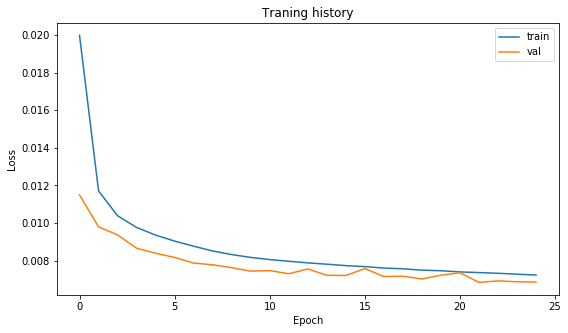

In [17]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

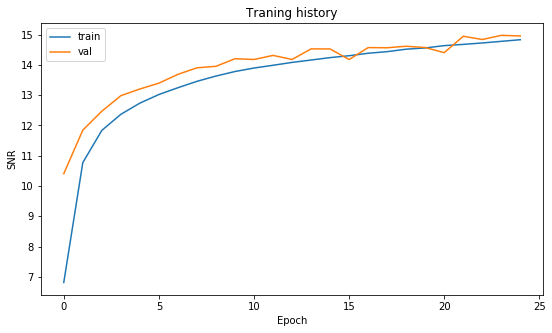

In [18]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [19]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

## Test

In [20]:
X_test = torch.load("../data/processed/noisy/test/x_test.pt")
y_test = torch.load("../data/processed/noisy/test/y_test.pt")

In [21]:
lsg_test = LibriSpeechGenerator(config, X_test, y_test)
ls_test_generator = data.DataLoader(lsg_test, **_params)

In [22]:
X_test.shape

torch.Size([3874, 1, 65536])

In [23]:
# Print validation metric before trainer
print("SNR (Test): {}".format(m_snr(lsg_test.X, lsg_test.y).item()))

SNR (Test): 10.058753967285156


In [24]:
test_loss, test_metric = 0.0, 0.0
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        test_loss += m_loss(outputs, local_labels).item() \
            * len(local_batch)

        test_metric += m_snr(outputs, local_labels).item() \
            * len(local_batch)
        
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)

    test_loss /= len(lsg_test)
    test_metric /= len(lsg_test)

In [26]:
import os

test_history = {
    'SNR_ini': m_snr(lsg_test.X, lsg_test.y).item(),
    'SNR': test_metric,
    'loss': test_loss
}

with open(os.path.join(config.writer_path, 'test_history.json') , 'w') as fp:
    json.dump(test_history, fp)